# Modelos de Machine Learning
## Introdução

A análise de ML abaixo foi realizada utilizando a base de dados que foi obtida via WebScraping atraveś dos sites: https://www.legislabrasil.org/ e no https://www.politicos.org.br/, utilizando os notebooks Rank_pol_V3.ipynb e Ranking_pol_site2.ipynb. Com aplicação das bibliotecas Selenium e BeautifulSoup.

Esses dois sites classificam dando notas aos deputados federais em atividade no Brasil, a análise foi feita para o ano de 2022. Cada site tem suas metricas para a nota. 
<br>
<br>
A nota final do primeiro site (**Legisla Brasil**) é uma média de 17 notas que são divididas em 4 grupos:
   1. PRODUÇÃO LEGISLATIVA: Mede o trabalho efetuado pelo parlamentar na elaboração, análise e votação de instrumentos legislativos.
   2. FISCALIZAÇÃO: Mede a fiscalização que o deputado concretiza em relação ao Executivo Federal
   3. MOBILIZAÇÃO: Mede a capacidade do parlamentar de articulação e cooperação com outros agentes políticos
   4. ALINHAMENTO PARTIDÁRIO: Alinhamento partidário do parlamentar em relação à votação da maioria do seu partido. <br>

Cada grupo é uma média de alguns indicadores: <br> 
**Produção Legislativa** <br>
1. Apresentação de projetos: Categoria básica para a análise da atividade legislativa. Se contabiliza o número de projetos - independente se autoria própria ou co-autoria - apresentados pelo parlamentar.
2. Protagonismo de autoria: Diferentemente da primeira, esse indicador isola os projetos encabeçados pelos parlamentares, avaliando o protagonismo do autor frente às matérias apresentadas por este.
3. Relevância das autorias: A partir da criação de categorias, alta e média relevância, os projetos são divididos a partir do impacto social que apresentam. Os projetos de alto impacto afetam diretamente políticas materiais, como a Reforma da Previdência; enquanto os de médio impacto estão mais relacionados às questões subjetivas como nomeação de estradas e condecorações, por exemplo.
4. Nº de votos em separado apresentados: O regimento parlamentar apresenta diversas ferramentas para a apresentação de discordâncias e mudanças no resultado. A apresentação de votação em separado permite ao parlamentar apresentar um ponto de vista diferente ao consenso gerado pelo Colegiado.
5. Nº de substitutivos apresentados: Outra ferramenta disponível é a apresentação de substitutivos. Esse mecanismo permite ao apresentar e disputar uma solução diferente da proposta pelo autor do projeto
6. Nº de relatorias apresentadas: Parte da atividade legislativa, o parlamentar responsável pela relatoria determina sobre a aprovação ou prejuízo de matérias.
7. Nº presença em Plenário: Frequência com a qual o parlamentar tem participado dos deputados deliberativos do Plenário.
8. Emendas de Plenário: Proposições feitas pelos parlamentares durante as sessões plenárias, com o objetivo de alterar um projeto de lei em tramitação.<br>

**Fiscalização**<br>

9. Nº de solicitações de informações protocoladas: Dimensão de fiscalização reativa. Os parlamentares podem usar dessa ferramenta para fiscalizar o poder público. Referência ao número total de requerimentos de informação protocolados.
10. Proposta de fiscalização e controle protocoladas: Dimensão da fiscalização preventiva, propositiva. Relaciona-se ao número de propostas de fiscalização protocoladas.
11. Recebimento de emendas parlamentares (emendas empenhadas): Recurso disponibilizado por todos os parlamentares. Calcula-se o montante de orçamento empenhado pelo Executivo.
12. Emendas de Medidas Provisórias: Medidas provisórias são um instrumento utilizado pelo presidente com força de lei. O Executivo envia para o Legislativo, e os parlamentares possuem um tempo limitado para propor emendas à proposição do Executivo.
13. Emendas de orçamento: Proposições feitas pelos parlamentares em projetos de lei orçamentária, que são enviados do Executivo para o Legislativo (Lei de Diretrizes Orçamentárias e Lei Orçamentária Anual).

**Mobilização**<br>

14. Projetos de autoria com status especial: O regime de tramitação pode atrasar ou acelerar a aprovação de um projeto legislativo. Ter um status especial ao projeto garante que sua tramitação seja mais rápida. Além disso, demonstra uma capacidade de articulação, pois, quando não é atribuída pelo próprio Presidente, requer que a maioria do Plenário se manifeste favoravelmente.
15. Cargos ocupados na legislatura: Referência ao número total de cargos institucionais ocupados pelos parlamentares. Indica capacidade de articulação e influência com seu partido e com seus pares.
16. Nº de requerimentos de Audiência Pública: As audiências públicas são o espaço para que a sociedade civil se manifeste sobre determinado projeto parlamentar. Um número de requerimentos de Audiência Pública protocolados demonstra uma vontade parlamentar de aproximação com agentes externos ao Parlamento, atividade importante para um parlamentar.

**Alinhamento partidário**<br>

17. Desvios da posição majoritária do partido em votações: Cálculo de desvio do parlamentar em relação à maioria do partido nas votações de projetos de lei tramitados na Câmara.<br>


A nota final do segundo site (**Ranking dos Políticos**) é uma média de 4 notas de acordo com a metodologia fornecida  pelo próprio site: <br>
Fórmula:<br>

[((APx3)+(AD/3))/4] + AC + OT = Nota Final<br>

AP = Antiprivilégio<br>
AD = Antidesperdício<br>
AC = Anticorrupção<br>
OT = Outros<br>
Aplicando a seguinte metodologia pelo site:<br>
**Pesos** <br>
- Para calcular a pontuação final dos políticos, aplicar os seguintes pesos

   - Antiprivilégios (Votações): 3x <br>
   - Antidesperdício (Presenças e Economia de Verbas): 3÷ <br>
   - Anticorrupção (Ficha Limpa): quando há processos, subtrai pontos da nota final <br>
   - Outros: soma ou subtrai pontos da nota final. <br>
<br>

**Obs:** A montagem da fórmula exibida no site ficou confusa, após verificação foi constatado que faltava um ( ) e foi corrigida aqui na apresentação. <br>

Cada nota é descrita no site e explicada da seguinte forma:

**Antiprivilégios** - O posicionamento dos parlamentares nas principais votações do Congresso é avaliado de acordo com a orientação do nosso Conselho. O aproveitamento de acerto nos votos reflete a nota do político neste critério. O Ranking avalia apenas parlamentares que ficam no mínimo 06 meses em seus respectivos mandatos. 

**Antidesperdício** - Políticos que não faltam ao trabalho e que economizam na Cota Parlamentar e Verba de Gabinete ganham pontos no ranking.
   - Presenças nas sessões deliberativas: A nota varia de acordo com taxa de comparecimento do político durante o período em que ele esteve em exercício. Faltas justificadas contam como presença.

   - Economia de Verbas: O desempenho neste quesito é definido pelo percentual economizado pelo político em relação à sua cota parlamentar e verba de gabinete disponíveis enquanto esteve em exercício.

   - Cota Parlamentar: Valor mensal para custear as despesas do mandato. Seu valor varia de acordo com o estado de origem do parlamentar, por conta dos diferentes custos de passagens aéreas para Brasília.

   - Verba de Gabinete: É o valor mensal destinado para pagar o salário dos assessores dos parlamentares.
<br>

**Anticorrupção** - Os parlamentares condenados em crimes, principalmente contra a administração pública, ou que respondem a inquéritos do STF, perdem pontos no Ranking dos Políticos.
<br>

**Outros** - Iniciativas relevantes não previstas nos demais critérios podem gerar o acúmulo ou a perda de pontuações extras para os parlamentares. Os pontos são subtraídos da nota final apurada nos demais critérios.
<br>
<br>

Após a análise da composição das notas foi observado que o quesito **Antiprivilégio** abre espaço para se tornar uma variável subjetiva, já que depende de um conselho para julgar o posicionamento do deputado. E apesar da composição do conselho ser pública não fica claro como ela é feita o que abre espaço para que seu posicionamento seja enviesado. E com o agravante dessa nota ser a que tem peso maior na composição final. 

O **objetivo** principal dessa análise é verificar se as 4 notas do Legisla Brasil (site 1) explicam a variabilidade da nota do Ranking dos políticos (site 2) usando um modelo de regressão linear.

## Machine Learning

In [114]:
# bibliotecas
import pandas as pd #processamento de dados
import numpy as np #algebra linear
import matplotlib.pyplot as plt # Matlab-Style
from pandas.plotting import scatter_matrix 
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*arg, **kwargs):
    pass
warnings.warm = ignore_warn #ignorar avisos chatos (do sklearn e seaborn)

from scipy import stats
from scipy.stats import norm, skew #para analises estatítiscas

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # limita saídas de tipos floats 
                                                                    # a 3 casas decimais
from subprocess import check_output
# print(check_output(["ls"]).decode("utf8")) #checar os arquivos disponiveis no diretório


# from sklearn import model_selection
# from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

In [78]:
# Carregando os dados
dados = pd.read_csv('df_after_AD.csv', dtype={'ideologia':'category'})

In [79]:
dados.head(1)

,Unnamed: 0,nome,estado,partido,ideologia,n_prod_leg,n_fisc,n_mobi,n_alin_partd,avg_site1,nota_site2
0,0,abou anni,São Paulo,UNIÃO,direita,3.800,0.900,2.400,6.400,2.853,6.550


In [80]:
# Visualizando as dimensões
dados = dados.drop('Unnamed: 0', axis=1)
dados.shape

(488, 10)

In [81]:
dados.head(2)

,nome,estado,partido,ideologia,n_prod_leg,n_fisc,n_mobi,n_alin_partd,avg_site1,nota_site2
0,abou anni,São Paulo,UNIÃO,direita,3.800,0.900,2.400,6.400,2.853,6.550
1,acacio favacho,Amapá,MDB,centro,2.600,0.200,2.100,6.400,2.029,6.120


#### Adicionando a feature região, que específica de qual regiao do Brasil é o deputado

In [82]:
#regiões do Brasil e seus estados
norte = ['Amazonas', 'Roraima', 'Amapá', 'Pará', 'Tocantins', 'Rondônia', 'Acre']
nordeste = ['Maranhão', 'Piauí', 'Ceará', 'Rio Grande do Norte', 'Pernambuco', 'Paraíba',\
            'Sergipe', 'Alagoas', 'Bahia']
centro_oeste = ['Mato Grosso', 'Mato Grosso do Sul', 'Goiás', 'Distrito Federal']
sudeste = ['São Paulo', 'Rio de Janeiro', 'Espírito Santo', 'Minas Gerais']
sul = ['Paraná', 'Rio Grande do Sul', 'Santa Catarina']
regiao = []

In [83]:
regiao = ['norte' if x in norte else 'nordeste' if x in nordeste else 'centro oeste' if x in centro_oeste\
          else 'sudeste' if x in sudeste else 'sul' for x in dados.estado]

In [84]:
dados.insert(2, 'regiao', regiao)

In [85]:
dados.head(2)

,nome,estado,regiao,partido,ideologia,n_prod_leg,n_fisc,n_mobi,n_alin_partd,avg_site1,nota_site2
0,abou anni,São Paulo,sudeste,UNIÃO,direita,3.800,0.900,2.400,6.400,2.853,6.550
1,acacio favacho,Amapá,norte,MDB,centro,2.600,0.200,2.100,6.400,2.029,6.120


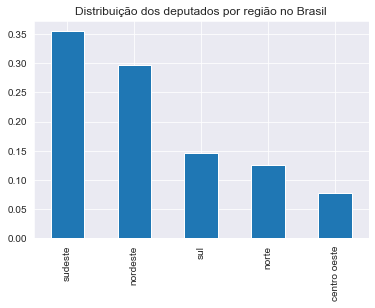

In [10]:
dados.regiao.value_counts(1).plot.bar()
plt.title('Distribuição dos deputados por região no Brasil')
plt.show()


A maior parte da representação na câmara são de deputados da região Sudeste e Nordeste abraçando juntas quase que 65% do total.

In [11]:
dados.groupby(['regiao', 'ideologia'])[['avg_site1', 'nota_site2']].mean()

avg_site1  nota_site2
regiao       ideologia                       
centro oeste centro         3.619       6.074
             direita        3.279       6.550
             esquerda       5.186       3.243
nordeste     centro         2.512       6.127
             direita        2.557       6.211
             esquerda       3.991       3.500
norte        centro         2.485       6.247
             direita        2.970       6.318
             esquerda       4.189       3.314
sudeste      centro         2.871       6.479
             direita        3.140       6.679
             esquerda       4.705       3.266
sul          centro         2.756       6.900
             direita        3.180       7.052
             esquerda       4.478       3.001

Pelo agrupamento dos dados por região o comportamento ainda segue o mesmo padrão. Em todas as regiões os partidos com ideologias classificadas em Centro e Direita tem nota mais baixa no site 1 e as mais altas no site 2. E para ideologias de esquerda a nota é mais alta no site 1 e a mais baixa do site 2.

In [12]:
dados.groupby(['regiao', 'ideologia'])[['ideologia']].count().unstack()

ideologia                 
ideologia       centro direita esquerda
regiao                                 
centro oeste        11      20        7
nordeste            32      69       44
norte               25      23       13
sudeste             38     100       35
sul                 28      27       16

A tabela acima mostra a distribuição de deputados por região para cada classificação de Ideologia do seu partido. E mostra que há maioria de partidos de Direita em 3 das 5 regiões, ficando atrás dos partidos de Centro apenas nas regiões Norte e Sul. Já a esquerda não é maioria em nenhuma região, e sendo minoria em 4 das 5 regiões, com excessão do Nordeste.
Isso mostra que a representatividade dos deputados do Brasil no ano de 2022 tem a Direita como sua representante majoritaria.

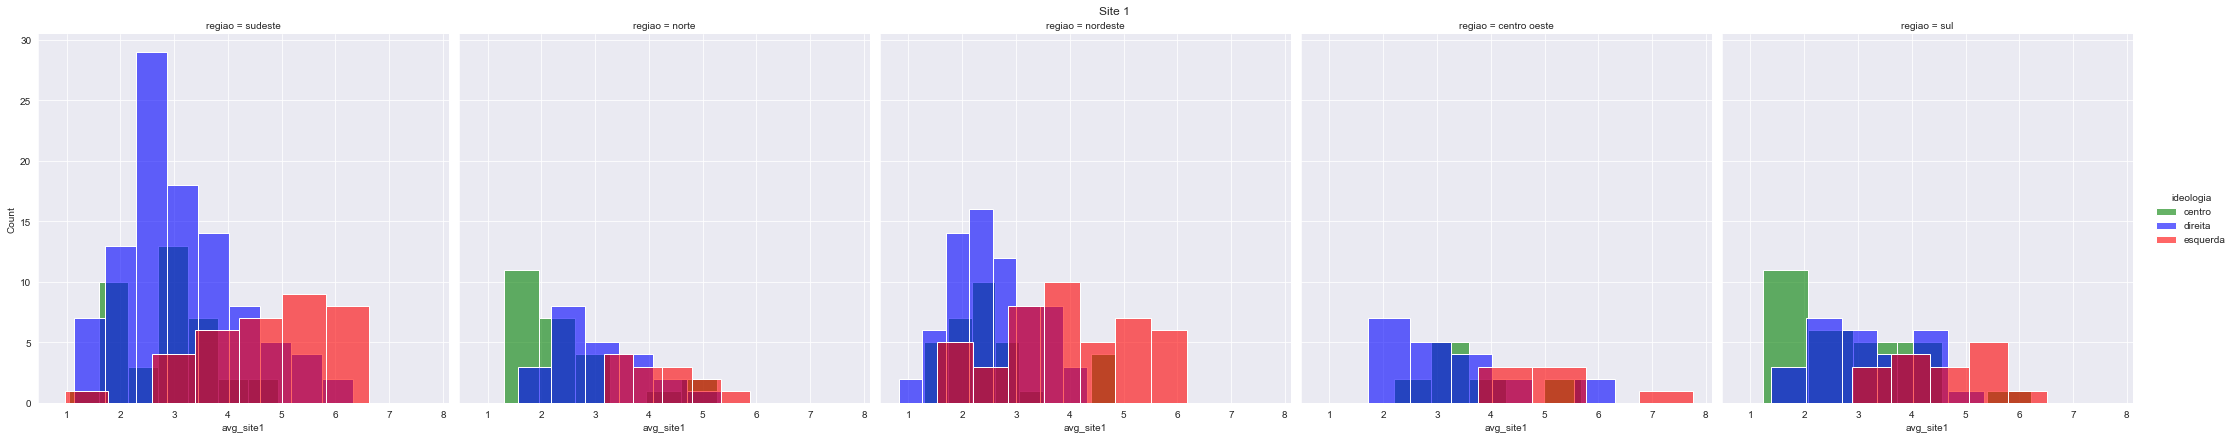

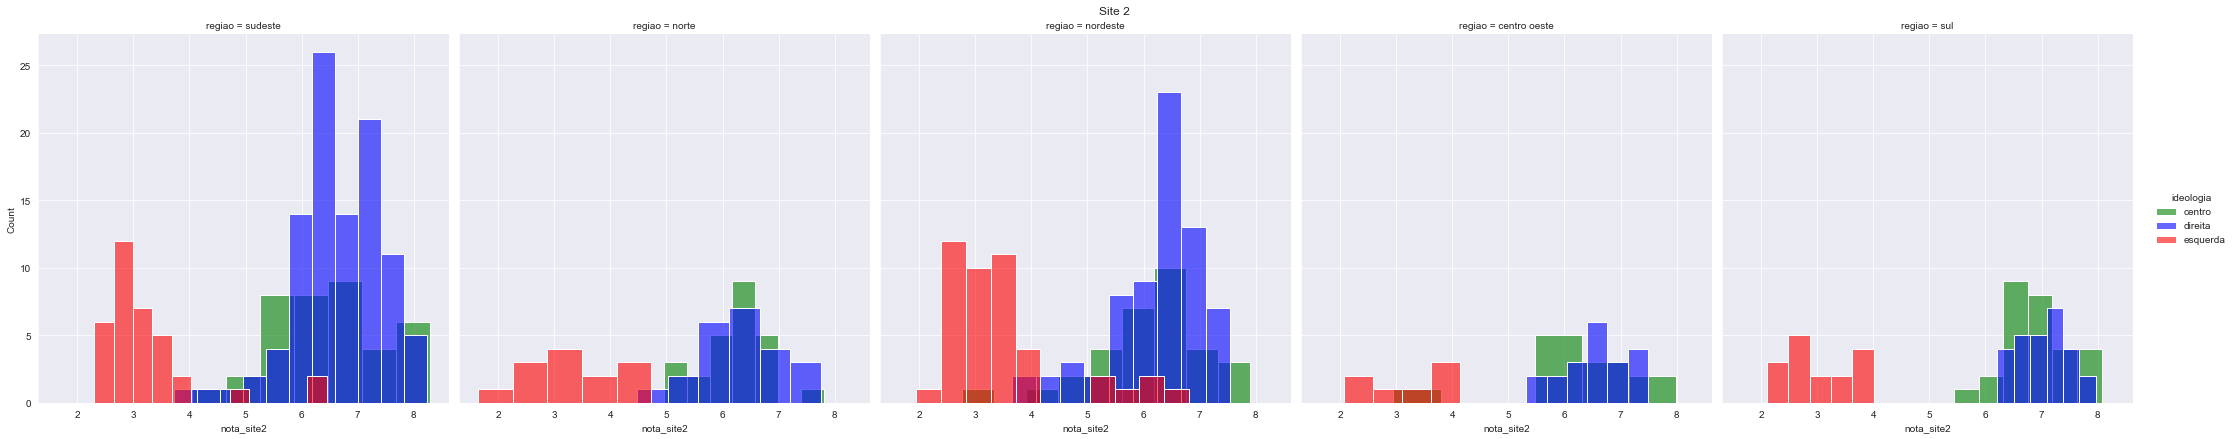

In [18]:
g = sns.FacetGrid(dados, col="regiao", hue="ideologia", palette = ["green", "blue", "red"], height=6)
g.map(sns.histplot, "avg_site1", alpha=.6)
g.add_legend()
g.fig.suptitle('Site 1', y=1.01)

g2 = sns.FacetGrid(dados, col="regiao", hue="ideologia", palette = ["green", "blue", "red"], height=6)
g2.map(sns.histplot, "nota_site2", alpha=.6)
g2.add_legend()
g2.fig.suptitle('Site 2', y=1.01)
plt.show()

Pode-se perceber a semelhança do comportamento das notas do Site 1 e do Site 2 quando olhamos para as notas divididas por região e quando olhamos para o comportamento da população dos dados. O site 1 tem notas maiores para partidos de Esquerda e o site 2 para partidos de Centro e Direita.

### Comçando os ajustes para inicio do treinamento dos modelos de ML

**nota_site2** é a variável que desejamos predizer, no caso desse problema é a variável que queremos comparar com as variáveis independentes para saber se elas explicam a sua variabilidade.

In [133]:
# dividindo o dataset
treino_M, teste_M = train_test_split(dados, 
                                test_size=0.3,
                                random_state=42
                               )
treino_M.shape, teste_M.shape

((341, 11), (147, 11))

 O subset de testes será usado somente no final da análise para evitar o data leakage.

In [134]:
y_test = teste_M.nota_site2.copy()
X_test = teste_M.drop(['nota_site2'], axis=1).copy()

### Treinando o modelo somente com as notas do site 1 (Modelo M1)

O primeiro modelo foi realizado considerando somente as notas (PRODUÇÃO LEGISLATIVA, FISCALIZAÇÃO, MOBILIZAÇÃO e ALINHAMENTO PARTIDÁRIO) oferecidas pelo Site 1 que foram usadas como variáveis preditoras para tentar explicar a nota do site 2 (politicos.org.br), utilizada como variável alvo.

In [135]:
# Variável target
y_M1 = treino_M.nota_site2.copy()

# Features preditoras
X_M1 = treino_M.drop(['nota_site2', 'nome', 'ideologia', 'estado', 'partido', 'avg_site1', 'regiao'], axis=1).copy()

print(f"Número de linhas {X_M1.shape[0]}")
X_M1.head()

Número de linhas 341


,n_prod_leg,n_fisc,n_mobi,n_alin_partd
3,6.400,2.900,7.300,10.000
417,1.900,0.000,1.500,6.400
173,6.700,3.100,6.100,0.900
60,2.000,0.700,1.800,6.400
110,3.600,0.900,4.800,8.200


In [136]:
#dividindo os dados de treino em um subset de treino e validação com uma amostra estratificada
X_train_M1, X_val_M1, y_train_M1, y_val_M1 = train_test_split(
    X_M1, y_M1, 
    test_size=0.3,
    random_state=42
)

X_train_M1.shape, y_train_M1.shape, X_val_M1.shape, y_val_M1.shape

((238, 4), (238,), (103, 4), (103,))

In [137]:
# Treino do modelo M1
modelo_M1 = LinearRegression()
modelo_M1.fit(X_train_M1, y_train_M1)

LinearRegression()

In [138]:
modelo_M1.score(X_val_M1, y_val_M1)

0.2731510508907977

In [139]:
# Cross Validation
scoring = ['r2', 'neg_mean_absolute_error']
for score in scoring:
    cv_scores = cross_val_score(modelo_M1, X_val_M1, y_val_M1,
                               cv=5,
                               scoring=score
                               )
    print(f"Acurácia no Cross-validation pela métrica {score} é: {round(cv_scores.mean(), 4)}")

Acurácia no Cross-validation pela métrica r2 é: 0.3147
Acurácia no Cross-validation pela métrica neg_mean_absolute_error é: -1.0612


#### Avaliação do modelo M1

Somente com as notas do site 1 o modelo preditivo fica com um desempenho muito ruim. Como critério de avaliação do modelo foi utilizado o valor do **R²**. No subset de validação foi utilizada a técnica Cross Validation, e foi obtido um valor médio de 0,315. Verificando-se que o modelo de regressão explica **31,5%** da variância. A teoria diz que quanto mais variância for explicada pelo modelo de regressão, mais próximos os pontos de dados estarão em relação à linha de regressão ajustada. Nesse caso um desempenho ruim.

E para neg_mean_absolute_error do sklearn, teve um **MAE**: -1,0612

### Treinando o Modelo M2, com a variável categórica "ideologia"

Porque utilizar essa variável?
<br>
Como foi visto na análise dos dados e reforçado nesse notebook há uma separação das notas de acordo com a ideologia política do partido ao qual o candidato faz parte.

In [93]:
colunas_cat = ['ideologia']

#### Dividindo o dataset 

In [94]:
# Variável target
y_M2 = treino_M.nota_site2.copy()

# Features preditoras
X_M2= treino_M.drop(['nota_site2', 'nome', 'estado', 'partido', 'avg_site1', 'regiao'], axis=1).copy()

print(f"Número de linhas {X_M2.shape[0]}")
X_M2.head()

Número de linhas 341


,ideologia,n_prod_leg,n_fisc,n_mobi,n_alin_partd
3,direita,6.400,2.900,7.300,10.000
417,esquerda,1.900,0.000,1.500,6.400
173,direita,6.700,3.100,6.100,0.900
60,centro,2.000,0.700,1.800,6.400
110,direita,3.600,0.900,4.800,8.200


In [95]:
#dividindo os dados de treino em um subset de treino e validação com uma amostra estratificada
X_train_M2, X_val_M2, y_train_M2, y_val_M2 = train_test_split(
    X_M2, y_M2, 
    test_size=0.3,
    stratify=X_M2["ideologia"],
    random_state=42
)
X_train_M2.shape, y_train_M2.shape, X_val_M2.shape, y_val_M2.shape

((238, 5), (238,), (103, 5), (103,))

In [96]:
# verificando a estratificação entre amostra e população
display(X_train_M2["ideologia"].value_counts()/len(X_train_M2), dados["ideologia"].value_counts()/len(dados))

direita    0.500
centro     0.265
esquerda   0.235
Name: ideologia, dtype: float64

direita    0.490
centro     0.275
esquerda   0.236
Name: ideologia, dtype: float64

#### Pipeline
Utilizando um pipeline para transformar a variável categórica em numérica e construir o modelo de ML.

Como temos uma base de dados pequena, vamos usar validação cruzada pra garantir medidas precisas da qualidade do modelo.

In [97]:
t = [('str_categoricas', OneHotEncoder(handle_unknown='ignore'), colunas_cat)]

preprocessor = ColumnTransformer(transformers=t, remainder='passthrough')

In [98]:
modelo_M2 = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('lr',LinearRegression())])

In [99]:
modelo_M2.steps

[('preprocessor',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('str_categoricas',
                                   OneHotEncoder(handle_unknown='ignore'),
                                   ['ideologia'])])),
 ('lr', LinearRegression())]

In [100]:
modelo_M2.fit(X_train_M2, y_train_M2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('str_categoricas',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ideologia'])])),
                ('lr', LinearRegression())])

In [101]:
modelo_M2.score(X_val_M2, y_val_M2)

0.6498542674235368

### Usando o cross-validation

In [117]:
scoring = ['r2', 'neg_mean_absolute_error']
for score in scoring:
    cv_scores = cross_val_score(modelo_M2, X_val_M2, y_val_M2,
                               cv=5,
                               scoring=score
                               )
    print(f"Acurácia no Cross-validation pela métrica {score} é: {round(cv_scores.mean(), 4)}")

Acurácia no Cross-validation pela métrica r2 é: 0.5699
Acurácia no Cross-validation pela métrica neg_mean_absolute_error é: -0.7277


Com a adição da nova feature o modelo M2 conseguiu uma performance melhor que o anterior, apriximadamente **57%.**

E para neg_mean_absolute_error do sklearn, teve um **MAE**: -0.7277

In [103]:
coeff_df = pd.DataFrame(modelo_M2.steps[1][1].coef_, 
                        modelo_M2[:-1].get_feature_names_out(),
                        columns=['Coefficient'])
coeff_df

,Coefficient
str_categoricas__ideologia_centro,0.923
str_categoricas__ideologia_direita,1.154
str_categoricas__ideologia_esquerda,-2.077
remainder__n_prod_leg,0.080
remainder__n_fisc,-0.057
remainder__n_mobi,-0.031
remainder__n_alin_partd,-0.067


### Modelo M3
Além da categórica 'ideologia' a este modelo foi adicionado a categórica 'partido'.

In [104]:
colunas_cat = ['ideologia', 'partido']

In [105]:
# Variável target
y_M3 = treino_M.nota_site2.copy()

# Features preditoras
X_M3 = treino_M.drop(['nota_site2', 'nome', 'estado', 'avg_site1', 'regiao'], axis=1).copy()

print(f"Número de linhas {X_M3.shape[0]}")
X_M3.head()

Número de linhas 341


,partido,ideologia,n_prod_leg,n_fisc,n_mobi,n_alin_partd
3,NOVO,direita,6.400,2.900,7.300,10.000
417,PDT,esquerda,1.900,0.000,1.500,6.400
173,UNIÃO,direita,6.700,3.100,6.100,0.900
60,SOLIDARIEDADE,centro,2.000,0.700,1.800,6.400
110,PTB,direita,3.600,0.900,4.800,8.200


In [106]:
#dividindo os dados de treino em um subset de treino e validação com uma amostra estratificada
X_train_M3, X_val_M3, y_train_M3, y_val_M3 = train_test_split(
    X_M3, y_M3, 
    test_size=0.3,
    stratify=X_M3["ideologia"],
    random_state=42
)
X_train_M3.shape, y_train_M3.shape, X_val_M3.shape, y_val_M3.shape

((238, 6), (238,), (103, 6), (103,))

In [107]:
# verificando a estratificação entre amostra e população
display(X_train_M3["ideologia"].value_counts()/len(X_train_M3))

display(dados["ideologia"].value_counts()/len(dados))

direita    0.500
centro     0.265
esquerda   0.235
Name: ideologia, dtype: float64

direita    0.490
centro     0.275
esquerda   0.236
Name: ideologia, dtype: float64

In [108]:
t = [('str_categoricas', OneHotEncoder(handle_unknown='ignore'), colunas_cat)]

preprocessor = ColumnTransformer(transformers=t, remainder='passthrough')

modelo_M3 = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('lr',LinearRegression())])

In [109]:
modelo_M3.fit(X_train_M3, y_train_M3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('str_categoricas',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ideologia', 'partido'])])),
                ('lr', LinearRegression())])

In [110]:
round(modelo_M3.score(X_val_M3, y_val_M3), 4)

0.6906108724110565

In [116]:
scoring = ['r2', 'neg_mean_absolute_error']
for score in scoring:
    cv_scores = cross_val_score(modelo_M3, X_val_M3, y_val_M3,
                               cv=5,
                               scoring=score
                               )
    print(f"Acurácia no Cross-validation, pela métrica {score} é: {round(cv_scores.mean(), 4)}")

Acurácia no Cross-validation, pela métrica r2 é: 0.6365
Acurácia no Cross-validation, pela métrica neg_mean_absolute_error é: -0.6944


In [112]:
coeff_df = pd.DataFrame(modelo_M3.steps[1][1].coef_, 
                        modelo_M3[:-1].get_feature_names_out(),
                        columns=['Coefficient'])
coeff_df

,Coefficient
str_categoricas__ideologia_centro,0.850
str_categoricas__ideologia_direita,0.946
str_categoricas__ideologia_esquerda,-1.795
str_categoricas__partido_AVANTE,-0.394
str_categoricas__partido_CIDADANIA,1.355
str_categoricas__partido_MDB,-0.328
str_categoricas__partido_NOVO,1.273
str_categoricas__partido_PATRIOTA,-0.316
str_categoricas__partido_PCdoB,-0.840
str_categoricas__partido_PDT,0.743


Uma melhora na base de treino, no subset de validação, foi alcançada com as mudanças para o modelo M3. Com a validação cruzada o valor de **R²** chegou a **63,6%**. 

E para neg_mean_absolute_error do sklearn, teve um **MAE**: -0.6944

## Avaliação do modelo escolhido (M3) utilizando a base de testes e outras métricas do SKlearn

In [113]:
round(modelo_M3.score(X_test, y_test), 3)

0.7

In [129]:
pred_M3 = modelo_M3.predict(X_test)

In [130]:
MEA_M3 = mean_absolute_error(y_test, pred_M3)
MSE_M3 = mean_squared_error(y_test, pred_M3)
r2_M3 = r2_score(y_test, pred_M3)

In [131]:
print(f'MEA para o modelo_M3 é: {round(MEA_M3, 3)}')
print(f'MSE para o modelo_M3 é: {round(MSE_M3, 3)}')
print(f'R² para o modelo_M3 é: {round(r2_M3, 3)}')

MEA para o modelo_M3 é: 0.649
MSE para o modelo_M3 é: 0.734
R² para o modelo_M3 é: 0.701


Com uma base de dados não vista pelo modelo o desempenho para o **R²** foi de **70%**.

### Conclusão


Dos três modelos estudados o M3 foi o que apresentou um R² mais alto. A esse modelo foram adicionadas *features* catégoricas com base na própria base de dados, isso porque foi observada uma tendência do Site 2 em agrupar notas de acordo com a ideologia do partido político dos deputados. 

No entanto, considerando somente as 4 notas do Site 1 (Modelo M1) **não é possível predizer** as notas do Site 2, muito provavelmente por conta da dependência das notas com a ideologia do partido. Que pode ser consequência do critério subjetivo observado na metodoligia adotada pelo Site 2 (Ranking dos políticos).

Comparando o desempenho do Modelo M2 e M3 é possível dizer que o partido do deputado também influencia na nota, ou seja, especificando qual o partido do candidato fica mais fácil predizer a nota que ele tem no Site 2 utilizando as informações do Site 1. 